In [1]:
import pytorch_lightning as pl
import torch
import Operator as op
import utils
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

g_dtype = torch.float32

Using cpu device


In [2]:
lattice_sites = 4
'''
h1 = op.Sx(0) + op.Sx(1)
h2 = op.Sz(0) + op.Sz(1)
o = [(op.Sx(1),)]
'''
h2_range = [(3.,3.)]

h1 = []
for l in range(lattice_sites):
  h1 = op.Sz(l) * op.Sz((l+1) % lattice_sites) + h1

h2 = []
for l in range(lattice_sites):
  h2 = op.Sx(l) + h2

o = []
for l in range(lattice_sites):
  o = op.Sx(l) * (1 / lattice_sites) + o

h1_mat = utils.get_total_mat_els(h1, lattice_sites)
h2_mat = utils.get_total_mat_els(h2, lattice_sites)
o_mat = utils.get_total_mat_els(o, lattice_sites)

h_map = utils.get_map(h1 + h2, lattice_sites)
o_map = utils.get_map(o, lattice_sites)

adding to sequence
adding to sequence
adding to sequence
adding to sequence
adding to sequence
adding to sequence
adding to sequence
adding to sequence


In [3]:
from torch.utils.data import Dataset, DataLoader
#setting up the datamodule

class train_data(Dataset):
    def __init__(self, lattice_sites, h_mat_list, h_ranges_list, o_mat, t_min=0, t_max=1):
        
        assert(len(h_mat_list) - 1 == len(h_ranges_list))
        #exact sampling for now
        self.spins = utils.get_all_spin_configs(lattice_sites).type(g_dtype)

        #saving ranges to generate alpha values each batch
        self.t_min = t_min
        self.t_max = t_max
        self.h_ranges_list = h_ranges_list

        #saving mat elements to pass to training loop with respective multipliers each loop
        self.h_mat_list = h_mat_list
        self.o_mat = o_mat
        
    def __len__(self):
        #just setting 100000 as dataset size to get 100000 alphas for one epoch
        return 100000

    def __getitem__(self, index):
        #creating the random alpha array of numspins with one value of (t, h_ext1, ..)
        alpha_arr = torch.zeros((self.spins.shape[0], (len(self.h_mat_list))))
        for i in range( len(self.h_mat_list) - 1 ):
            max = self.h_ranges_list[i][1]
            min = self.h_ranges_list[i][0] 
            alpha_arr[:, i+1] = ( (max - min) * torch.rand((1,1)) + min )
        alpha_0 = alpha_arr.clone()
        alpha_arr[:, 0] = ( ( self.t_max - self.t_min ) * torch.rand((1,1)) + self.t_min )
        h_mat = self.h_mat_list[0]
        for i in range(len(self.h_mat_list) - 1):
            h_mat = torch.cat((h_mat, alpha_arr[0, i +1] * self.h_mat_list[i + 1]), dim=2)

        return self.spins, alpha_arr, alpha_0, h_mat, self.o_mat

In [4]:
class val_data(Dataset):
    def __init__(self, ED_data, ext_params : tuple, o_mat):
        #exact sampling for now
        self.spins = utils.get_all_spin_configs(lattice_sites).type(g_dtype)
        #target Magnetizations from ED Code that 
        self.t_arr = torch.from_numpy(ED_data[:, 0]).type(g_dtype).unsqueeze(1)
        self.O_target = torch.from_numpy(ED_data[:, 2]).type(g_dtype)

        #saving mat elements to pass to val loop
        self.o_mat = o_mat
        self.ext_params = torch.zeros((1, len(ext_params)), dtype=g_dtype)
        for i in range(len(ext_params)):
            self.ext_params[:, i] = ext_params[i]
        print(self.ext_params.dtype)
        
    def __len__(self):
        #just setting 100000 as dataset size to get 100000 alphas for one epoch
        return self.t_arr.shape[0]

    def __getitem__(self, index):
        t_arr = self.t_arr[index].repeat(self.spins.shape[0], 1)
        ext_param = self.ext_params.repeat(self.spins.shape[0], 1)
        return self.spins, torch.cat((t_arr, ext_param), dim=1), self.o_mat, self.O_target[index]


ED_data = np.loadtxt('ED_data.csv', delimiter=',')
#print(ED_data)
val_data = val_data(ED_data, (3,), o_mat)
val_dataloader = DataLoader(val_data, batch_size=len(val_data), num_workers=2)
#print(val_data[1])

torch.float32


In [5]:
data = train_data(lattice_sites, [h1_mat, h2_mat], h2_range, o_mat)
train_dataloader = DataLoader(dataset=data, batch_size=2, num_workers=2)
#data_iter = iter(train_dataloader)

#spins, alpha, alpha_0, h_mat, o_mat_el = next(data_iter)
#print(alpha_0, '\n', alpha)
#print(alpha, '\n' ,spins)#, '\n' ,h_mat.shape, '\n', o_mat_el.shape)

In [6]:
import torch
from torch.nn import functional as F
import pytorch_lightning as pl
from torch import nn
import matplotlib.pyplot as plt

class Model(pl.LightningModule):

  def __init__(self, lattice_sites, h_map, o_init_map):
    '''
    Initializer for neural net
    Parameters
    __________
    lattice_sites: int
    h_mat_list: tensor, dtype=complex
      the matrix elements of the hamiltonian 
      shape = (num_ext_params, )
    '''
    super().__init__()
    self.lattice_net = nn.Sequential(
      nn.Conv1d(1, 8, kernel_size=2, padding=1, padding_mode='circular'),
      nn.ReLU(),
      nn.Conv1d(8, 16, kernel_size=2, padding=1, padding_mode='circular'),
      nn.Flatten(start_dim=1, end_dim=-1)
    )
    
    self.tNN = nn.Sequential(
      nn.Linear(2, 16),
      nn.ReLU(),
      nn.Linear(16, 32),
      nn.ReLU(),
      nn.Linear(32, 64)
    )

    self.psi = nn.Sequential(
      nn.Linear( 64 + 16 * ( lattice_sites + 2 ), 128 ),
      nn.ReLU(),
      nn.Linear(128, 64),
      nn.ReLU(),
      nn.Linear(64,2)
    )

    self.h_map = h_map.to(device)
    self.o_init_map = o_init_map.to(device)

  def forward(self, spins, alpha):
    #unsqueeze since circular padding needs tensor of dim 3
    lat_out = self.lattice_net(spins.unsqueeze(1))
    t_out = self.tNN(alpha)

    rad_and_phase = (self.psi(torch.cat((lat_out, t_out), dim=1)))
    psi = rad_and_phase[:, 0] * torch.exp( 1.j * rad_and_phase[:, 1] )
    return psi
    
  def call_forward(self, spins, alpha):
    '''
    makes forward callable with (num_alpha_configs, num_spin_configs)
    Parameters
    __________
    spins: tensor, dtype=float
      tensor of input spins to wave function 
      shape = (num_spin_configs, num_alpha_configs, lattice_sites)
    alpha: tensor, dtype=float
      other inputs to hamiltonian e.g. (time, ext_param) 
      shape = (num_spin_configs, num_alpha_configs, num_inputs)

    Returns
    _______
    psi: tensor, dtype=complex
      wave function for a combination of (spins, alpha) 
      size = (num_spin_configs, num_alpha_configs, 1)
    '''
    spin_shape = spins.shape
    alpha_shape = alpha.shape
    
    spins = torch.flatten(spins, end_dim=-2)
    alpha = torch.flatten(alpha, end_dim=-2)
    
    psi = self(spins, alpha)
    return psi.reshape( spin_shape[0], spin_shape[1], 1)

  def call_forward_sp(self, sprimes, alpha):
    '''
    makes forward callable with (num_alpha_configs, num_spin_configs, num_sprimes)
    Parameters
    __________
    spins: tensor, dtype=float
      tensor of input spins to wave function 
      shape = (num_spin_configs, num_alpha_configs, num_sprimes, lattice_sites)
    alpha: tensor, dtype=float
      other inputs to hamiltonian e.g. (time, ext_param) are broadcasted to s' shape
      shape = (num_spin_configs, num_alpha_configs, num_inputs)

    Returns
    _______
    psi: tensor, dtype=complex
      wave function for a combination of (spins, alpha) 
      size = (num_spin_configs, num_alpha_configs, num_sprimes, 1)
    '''
    sprimes_shape = sprimes.shape
    alpha_shape = alpha.shape
    
    alpha = alpha.unsqueeze(2)
    alpha = alpha.broadcast_to(alpha_shape[0], alpha_shape[1], sprimes_shape[2], alpha_shape[2])

    sprimes = torch.flatten(sprimes, end_dim=-2)
    alpha = torch.flatten(alpha, end_dim=-2)
    
    psi = self(sprimes, alpha)
    return psi.reshape( sprimes_shape[0], sprimes_shape[1], sprimes_shape[2], 1)
  
  def training_step(self, batch, batch_idx):
    spins, alpha, alpha_0, h_mat, o_mat = batch
    alpha.requires_grad = True
    #get psi(s, alpha)
    psi_s = self.call_forward(spins, alpha)

    #get s' and psi(s', alpha) for h
    sp_h = utils.get_sp(spins, self.h_map)
    psi_sp_h = self.call_forward_sp(sp_h, alpha)

    #get s' and psi(s', alpha) for o at t=0
    sp_o = utils.get_sp(spins, self.o_init_map)
    psi_sp_o = self.call_forward_sp(sp_o, alpha_0)
    psi_s_0 = self.call_forward(spins, alpha_0)
    
    #calc O_loc for h, o
    h_loc = utils.calc_Oloc(psi_sp_h, h_mat, spins)
    o_loc = utils.calc_Oloc(psi_sp_o, o_mat, spins)

    #calc dt_psi(s, alpha)
    dt_psi_s = utils.calc_dt_psi(psi_s, alpha)
    #print(dt_psi_s.shape, psi_s.shape)

    #calc loss
    loss = utils.train_loss(dt_psi_s, h_loc, psi_s_0, o_loc)
    return {'loss': loss}

  def validation_step(self, batch, batch_idx):
    spins, alpha, o_mat, o_target = batch
    print('measuring observable')
    
    psi_s = self.call_forward(spins, alpha)
    sp_o = utils.get_sp(spins, self.o_init_map)
    psi_sp_o = self.call_forward_sp(sp_o, alpha)
    o_loc = utils.calc_Oloc(psi_sp_o, o_mat, spins)
    val_loss, observable = utils.val_loss(psi_s, o_loc, o_target)
    
    fig, ax = plt.subplots(figsize = (6,10))
    print(alpha.shape, o_target.shape)
    ax.plot(alpha[:, 0, 0].cpu(), observable.cpu())
    ax.plot(alpha[:, 0, 0].cpu(), o_target.cpu())
    plt.show()
    return {'val_loss': val_loss}

    

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
    return optimizer

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
Running in fast_dev_run mode: will run a full train, val and test loop using 1 batch(es).

  | Name        | Type       | Params
-------------------------------------------
0 | lattice_net | Sequential | 296   
1 | tNN         | Sequential | 2.7 K 
2 | psi         | Sequential | 29.0 K
-------------------------------------------
32.0 K    Trainable params
0         Non-trainable params
32.0 K    Total params
0.128     Total estimated model params size (MB)
/home/nf020349/.local/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:103: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f'The dataloader, {name}, does not have many workers which may be a bottleneck.'
/home/nf020349/.loca

Training: 0it [00:00, ?it/s]

/home/nf020349/.local/lib/python3.6/site-packages/pytorch_lightning/trainer/supporters.py:74: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /pytorch/aten/src/ATen/native/Copy.cpp:240.)
  x = x.to(self.memory)


Validating: 0it [00:00, ?it/s]

measuring observable
torch.Size([187, 1]) torch.Size([187])
torch.Size([187, 16, 2]) torch.Size([187])


/home/nf020349/.local/lib/python3.6/site-packages/torch/_tensor.py:645: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


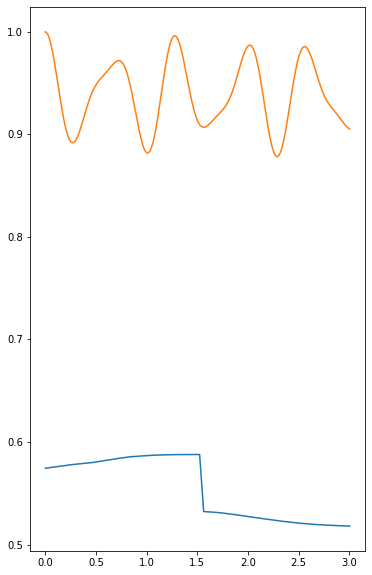

In [7]:
model = Model(lattice_sites, h_map, o_map)
#print(model)

trainer = pl.Trainer(fast_dev_run=True)
trainer.fit(model, train_dataloader, val_dataloader)